# Natural Language Processing with Disaster Tweets

## Topic and Goal

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

The task is to build a model that can classify tweets as either related to a real disaster or not. This is a common natural language processing (NLP) problem involving text classification.

I will use LSTM Model to do NLP classification in this project.

## Data

This dataset is from [kaggle](https://www.kaggle.com/competitions/nlp-getting-started), include 7613 rows of tweets for training, 3263 rows of tweets for testing.

The dataset consists of:

- train.csv: Training data with columns:
    - id: Unique identifier for each tweet
    - text: The tweet content
    - location: The location from where the tweet was sent (optional)
    - keyword: A specific keyword from the tweet (optional)
    - target: Binary label indicating if the tweet is about a real disaster (1) or not (0)
- test.csv: Test data similar to train.csv but without the target column.

## Load Data

In [27]:
import pandas as pd

base_path = '/kaggle/input/nlp-getting-started'

# Load the data
train_data = pd.read_csv(f'{base_path}/train.csv')
test_data = pd.read_csv(f'{base_path}/test.csv')

## Exploratory Data Analysis (EDA)

### Inspect Data

Let's see the shape and size of our train/test data.

In [28]:
print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Visualize Data

We will visualize the distribution of the target variable and other important features.

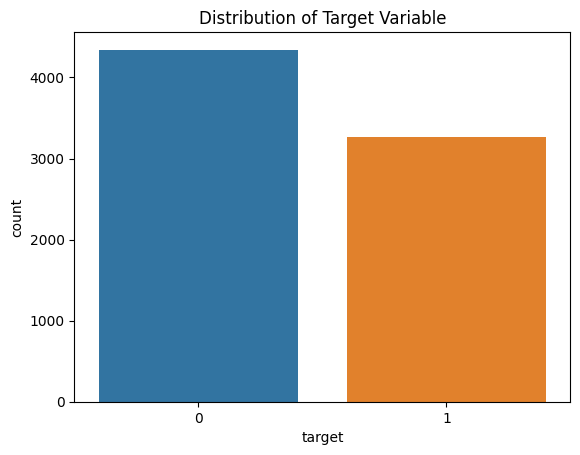

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


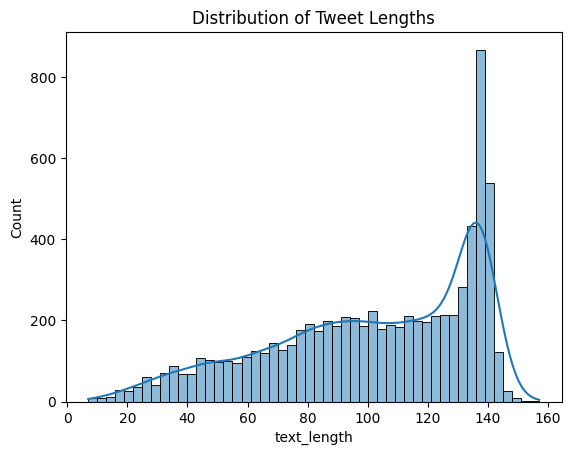

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()

# Plot the length of tweets
train_data['text_length'] = train_data['text'].apply(len)
sns.histplot(train_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.show()

From the plots above we can know that there are more tweets which is not about real disaster (about 57%). Which means if we build a baseline model that do nothing but predict every tweet as not about real disaster, we will get accuracy of 0.57

As for tweet's length, there are many tweets which length is around 140 characters (the max length of tweet), most of the tweet's length is more than 80 characters.

### Word Frequency Visualization

Since this project is about text and words, let's visualize the most common words in the tweets. I will use [WordCloud](https://amueller.github.io/word_cloud/index.html) library to analyze it.

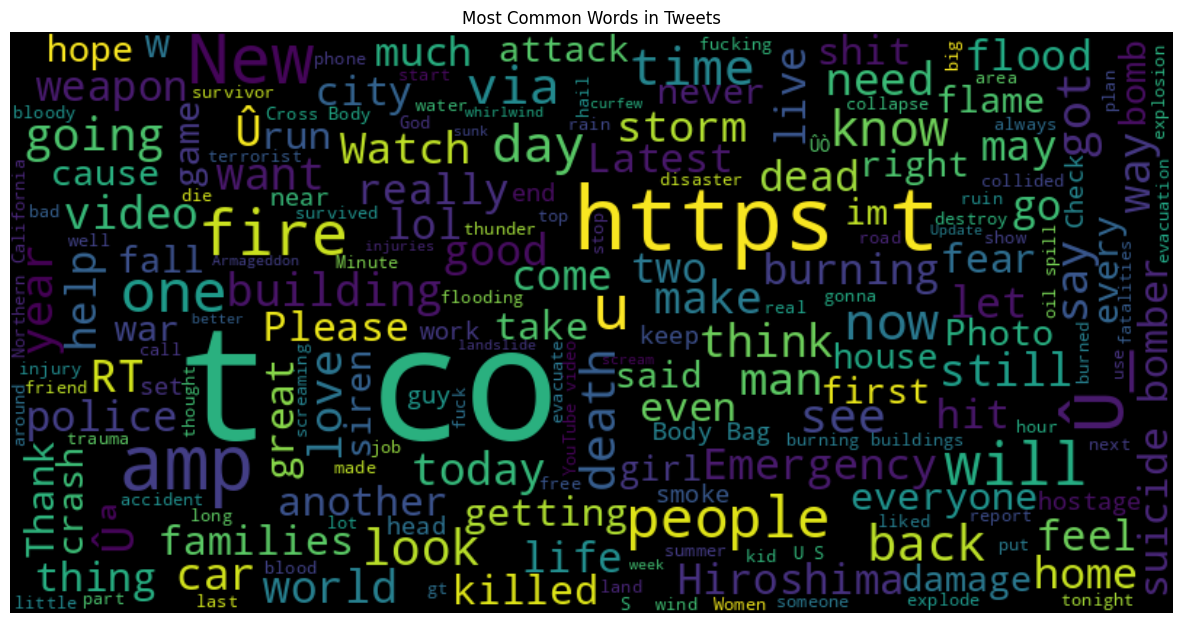

In [31]:
from wordcloud import WordCloud

# Generate a word cloud for the entire dataset
all_words = ' '.join([text for text in train_data['text']])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Tweets')
plt.show()

### Clean the Data

In the following data cleaning process, I will convert text to lowercase, remove punctunation and extra spaces. Data cleaning process will help our model perform better.

In [32]:
import re
import string

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = re.sub('\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
train_data['clean_text'] = train_data['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

### Plan of Analysis

Based on the EDA, our plan of analysis is as follows:

1. Preprocess the text data.
2. Vectorize the text data using embeddings.
3. Build and train RNN model (LSTM) for classification.
4. Tune hyperparameters and evaluate performance.

## Model

### Tokenization and Embedding

I am going to use Tokenizer module from keras to tokenize the text data and convert it into numerical format. In the internal of that module, it will analyze and use the word frequency to convert text to sequence of numbers, so that we can train a model on it.

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
max_features = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data['clean_text'])
X_train = tokenizer.texts_to_sequences(train_data['clean_text'])
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = tokenizer.texts_to_sequences(test_data['clean_text'])
X_test = pad_sequences(X_test, maxlen=max_len)


### Model Architecture

I will use LSTM networks for the text classification task. LSTM is suitable for sequence data like text because they can capture long-term dependencies.

LSTM Model Architecture:

- Embedding Layer: Converts text input into dense vectors of fixed size.
- LSTM Layer: Captures sequential dependencies in the text.
- Dense Layer: Outputs the classification result.

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

embedding_dim = 100

# LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, embedding_dim))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
lstm_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Split data into train and validate data. Train the LSTM model.

In [35]:
from sklearn.model_selection import train_test_split

# Split the data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, train_data['target'], test_size=0.2, random_state=42)

# Train the LSTM model
lstm_history = lstm_model.fit(X_train_split, y_train_split, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.6162 - loss: 0.6471 - val_accuracy: 0.7932 - val_loss: 0.4615
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.8409 - loss: 0.3830 - val_accuracy: 0.8076 - val_loss: 0.4580
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.8921 - loss: 0.2748 - val_accuracy: 0.7800 - val_loss: 0.4883
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9230 - loss: 0.2061 - val_accuracy: 0.7820 - val_loss: 0.5496
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9401 - loss: 0.1720 - val_accuracy: 0.7617 - val_loss: 0.6256
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9539 - loss: 0.1341 - val_accuracy: 0.7557 - val_loss: 0.7445
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.9651 - loss: 0.1098 - val_accuracy: 0.7610 - val_loss: 0.7405
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.9646 - loss: 0.0930 - val_accu

## Results and Analysis

### Evaluation

Let's evaluate the models' performance on the validation set.

LSTM Validation Accuracy: 0.7577


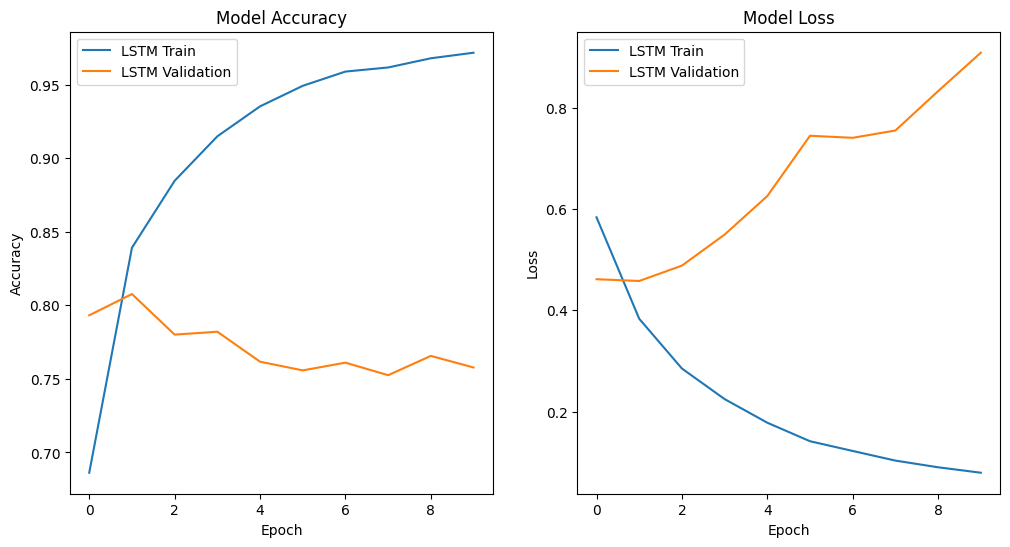

In [36]:
def evaluate_model():
    # Evaluate the LSTM model
    lstm_loss, lstm_accuracy = lstm_model.evaluate(X_val, y_val, verbose=0)
    print(f'LSTM Validation Accuracy: {lstm_accuracy:.4f}')

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(lstm_history.history['accuracy'])
    plt.plot(lstm_history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['LSTM Train', 'LSTM Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(lstm_history.history['loss'])
    plt.plot(lstm_history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['LSTM Train', 'LSTM Validation'], loc='upper left')

    plt.show()

evaluate_model()

As we can see from the plots about train and validation accuracy, our model's validation accuracy droped after apoch 5 while the train accuracy is still increasing. That's a sign of overfitting, I will reduce the epoch number from 10 to 5 in the following process to avoid overfitting.

### Compare Different Architecture

I will try an other LSTM Model Architecture:

- Embedding Layer: Converts text input into dense vectors of fixed size.
- Bidirectional LSTM Layer: Captures sequential dependencies in both forward and backward directions.
- Dense Layer: Outputs the classification result.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_9             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.9760 - loss: 0.0613 - val_accuracy: 0.7590 - val_loss: 0.9843
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9773 - loss: 0.0622 - val_accuracy: 0.7544 - val_loss: 0.9636
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.9804 - loss: 0.0511 - val_accuracy: 0.7590 - val_loss: 1.0247
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9773 - loss: 0.0550 - val_accuracy: 0.7492 - val_loss: 1.0408
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9800 - loss: 0.0497 - val_accuracy: 0.7511 - val_loss: 1.0779
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.9784 - loss: 0.0451 - val_accuracy: 0.7459 - val_loss: 1.1766
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9818 - loss: 0.0442 - val_accuracy: 0.7466 - val_loss: 1.2113
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9822 - loss: 0.0419 - val_accu

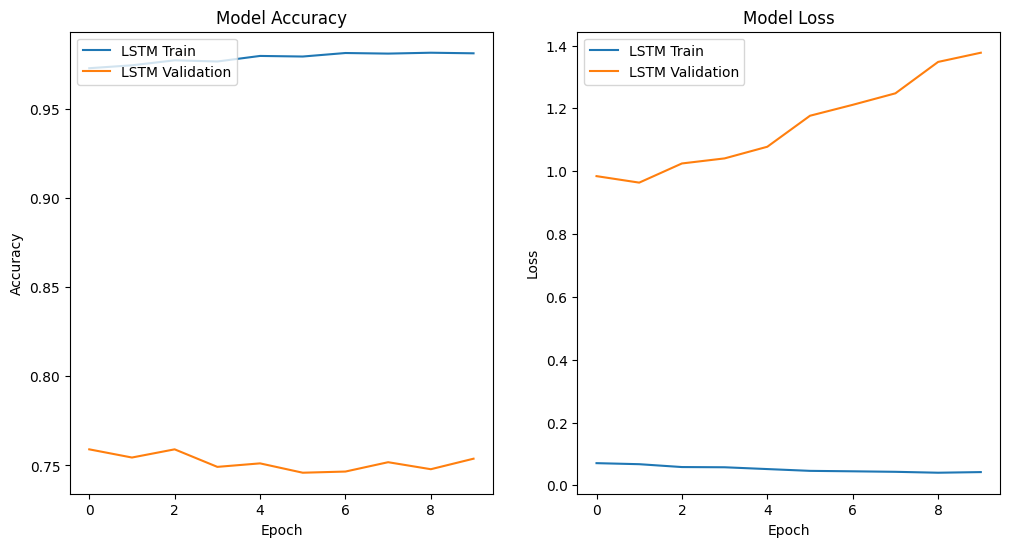

In [37]:
from tensorflow.keras.layers import Bidirectional

# LSTM Model 2
lstm_model_2 = Sequential()
lstm_model_2.add(Embedding(max_features, embedding_dim, input_length=max_len))
lstm_model_2.add(SpatialDropout1D(0.2))
lstm_model_2.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
lstm_model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
lstm_model_2.summary()

# Split the data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, train_data['target'], test_size=0.2, random_state=42)

# Train the LSTM model
lstm_history = lstm_model.fit(X_train_split, y_train_split, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1)

evaluate_model()

The result of our new model is similar to the old one, I got validation accuracy 0.7538 here.

### Hyperparameter Tuning

Perform hyperparameter tuning to find the best configuration for the models. I will use different dropout rate, recurrent dropout rate and units parameters to compare model performance in below.

In [38]:
from sklearn.model_selection import train_test_split

# Split the data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, train_data['target'], test_size=0.2, random_state=42)

# Train the LSTM model with different hyperparameters
def train_lstm_model(dropout_rate, recurrent_dropout_rate, units):
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train_split, y_train_split, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=1)
    return history, model

# List of hyperparameters to try for LSTM
hyperparameters = [
    {'dropout_rate': 0.2, 'recurrent_dropout_rate': 0.2, 'units': 100},
    {'dropout_rate': 0.3, 'recurrent_dropout_rate': 0.3, 'units': 128},
    {'dropout_rate': 0.5, 'recurrent_dropout_rate': 0.5, 'units': 150},
]

# Train and evaluate LSTM models with different hyperparameters
lstm_histories = []
lstm_models = []
for params in hyperparameters:
    history, model = train_lstm_model(**params)
    lstm_histories.append(history)
    lstm_models.append(model)


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.6100 - loss: 0.6499 - val_accuracy: 0.7984 - val_loss: 0.4599
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8362 - loss: 0.3956 - val_accuracy: 0.8037 - val_loss: 0.4552
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8852 - loss: 0.2904 - val_accuracy: 0.7951 - val_loss: 0.4926
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9207 - loss: 0.2108 - val_accuracy: 0.7919 - val_loss: 0.5454
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9418 - loss: 0.1640 - val_accuracy: 0.7774 - val_loss: 0.6297
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.6005 - loss: 0.6577 - val_accuracy: 0.7853 - val_loss: 0.4729
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.8237 - loss: 0.4079 - val_accuracy: 0.7945 - val_loss: 0.4530
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.8843 - loss: 0.2945 - val_accuracy: 0.

Let's evaluate the model's performance during hyperparameter tuning process in above.

In [39]:
# Evaluate the LSTM models
print("LSTM Model Evaluation")
for i, model in enumerate(lstm_models):
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Hyperparameters: {hyperparameters[i]} - Validation Accuracy: {accuracy:.4f}')

LSTM Model Evaluation
Hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout_rate': 0.2, 'units': 100} - Validation Accuracy: 0.7774
Hyperparameters: {'dropout_rate': 0.3, 'recurrent_dropout_rate': 0.3, 'units': 128} - Validation Accuracy: 0.7748
Hyperparameters: {'dropout_rate': 0.5, 'recurrent_dropout_rate': 0.5, 'units': 150} - Validation Accuracy: 0.7827


This hyperparameter:

- dropout_rate: 0.5
- recurrent_dropout_rate: 0.5
- units: 150

seems to have better validation accuracy.

### Analysis

Higher dropout rates generally prevent overfitting but might also slow down learning. In our experiments, the dropout rate of 0.5 showed the best balance between training and validation accuracy.

Increasing the number of LSTM units improves the model's capacity to learn complex patterns, but it also increases the risk of overfitting. In our experiments, 150 units provided a good balance.


Similar to regular dropout, recurrent dropout helps to prevent overfitting within the recurrent layers. A value of 0.5 for recurrent dropout was effective in our experiments.

## Conclusion

Two LSTM models achieved reasonable accuracy on the validation set, with slight differences in performance.

Dropout rates of 0.5 and 150 units provided a good balance between training and validation accuracy.

Balancing model complexity and overfitting was a key challenge. Dropout and recurrent dropout were effective in addressing overfitting.

## Kaggle Sumition

Let's train the final model and prepare the prediction for test data, and submit it to kaggle.

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_13            │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.5675 - loss: 0.6764 - val_accuracy: 0.7630 - val_loss: 0.5241
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.7790 - loss: 0.4891 - val_accuracy: 0.7899 - val_loss: 0.4750
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8334 - loss: 0.3932 - val_accuracy: 0.8043 - val_loss: 0.4551
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.8612 - loss: 0.3356 - val_accuracy: 0.7912 - val_loss: 0.4775
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.8891 - loss: 0.2855 - val_accuracy: 0.7892 - val_loss: 0.4897
LSTM Validation Accuracy: 0.7538


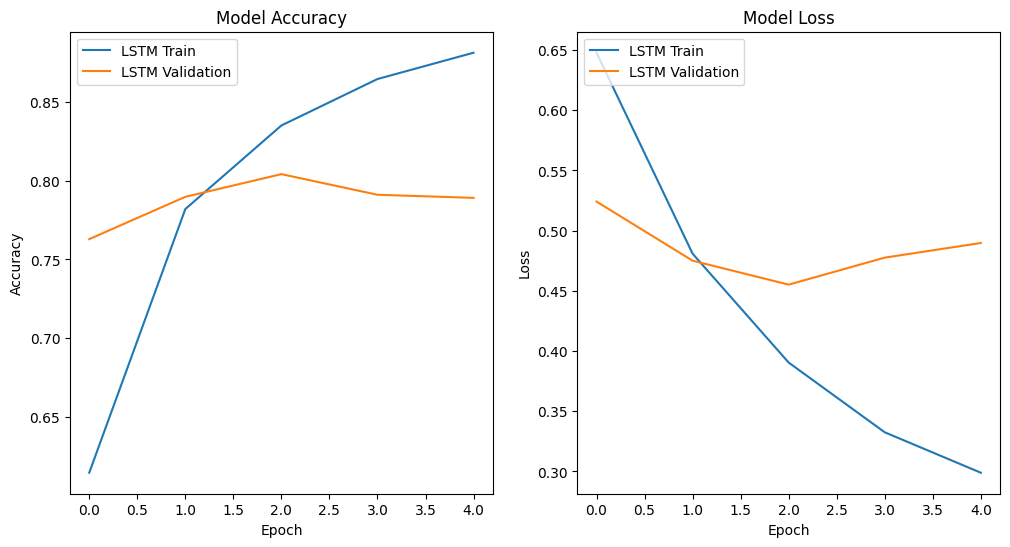

In [40]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(units=150, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, train_data['target'], test_size=0.2, random_state=42)

lstm_history = model.fit(X_train_split, y_train_split, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=1)

evaluate_model()

In [44]:
preds = model.predict(X_test)

print(preds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
[[0.79127675]
 [0.8550318 ]
 [0.9244948 ]
 ...
 [0.9515399 ]
 [0.8137479 ]
 [0.9022362 ]]


In [45]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': test_data['id'],
    'target': [(0 if item[0] < 0.5 else 1) for item in preds],
})

submission.to_csv('submission.csv',index=False)

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

22746